In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import madrigalWeb.madrigalWeb
import os
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2024"

maddat = madrigalWeb.madrigalWeb.MadrigalData('https://data.amisr.com/madrigal/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2016, 11, 23, 7,0)
et=datetime.datetime(2016, 11, 23, 15,0)

expList = maddat.getExperiments(instcodes['PFISR'],
                st.year, st.month, st.day, st.hour, st.minute, st.second,
                et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 30002700
realUrl: http://data.amisr.com/madrigal/showExperiment/?experiment_list=30002700
url: http://data.amisr.com/madrigal/madtoc/experiments0/2016/pfa/23nov16a
name: Themis36 - Auroral and convection measurements
siteid: 3
sitename: SRI
instcode: 61
instname: Poker Flat IS Radar
startyear: 2016
startmonth: 11
startday: 23
starthour: 6
startmin: 0
startsec: 58
endyear: 2016
endmonth: 11
endday: 23
endhour: 17
endmin: 0
endsec: 0
isLocal: True
madrigalUrl: http://https://data.amisr.com/madrigal
PI: Asti Bhatt
PIEmail: asti.bhatt@sri.com
uttimestamp: 1720757714
access: 0
Madrigal version: 3.4



In [5]:
# Get all the files associated with the experiment:
fileList = maddat.getExperimentFiles(expList[0].id)
for file in fileList:
    print(os.path.basename(file.name),'\tkindat:',file.kindat,'desc:',file.kindatdesc)

pfa20161123.001_ac_nenotr_03min.002.h5 	kindat: 1000203 desc: Ne From Power - Alternating Code (E-region) - 3 min
pfa20161123.001_ac_fit_03min.002.h5 	kindat: 2000203 desc: Fitted - Alternating Code (E-region) - 3 min
pfa20161123.001_lp_nenotr_01min.002.h5 	kindat: 1000101 desc: Ne From Power - Long Pulse (F-region) - 1 min
pfa20161123.001_lp_fit_01min.002.h5 	kindat: 2000101 desc: Fitted - Long Pulse (F-region) - 1 min
pfa20161123.001_lp_vvels_03min.002.h5 	kindat: 3000103 desc: Resolved Velocity - Long Pulse (F-region) - 3 min
pfa20161123.001_lp_vvels_01min.002.h5 	kindat: 3000101 desc: Resolved Velocity - Long Pulse (F-region) - 1 min


In [6]:
# Download a specific file from the experiment
fileList = maddat.getExperimentFiles(expList[0].id)
acfile=None
for file in fileList:
    if file.kindat == 2000203: # New kindat for Fitted - Alternating Code (E-region) - 3 min 
        acfile=file
        break
        
filename    = acfile.name
outfilename = os.path.basename(acfile.name)
result = maddat.downloadFile(filename,outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [7]:
# Explore the HDF5 madrigal metadata
with h5py.File(outfilename,'r') as f:
    for key1,val1 in f.items():
        print(key1,val1)
        for key2,val2 in val1.items():
            print(" ",key2,val2)        

Data <HDF5 group "/Data" (2 members)>
  Array Layout <HDF5 group "/Data/Array Layout" (23 members)>
  Table Layout <HDF5 dataset "Table Layout": shape (105754,), type "|V288">
Metadata <HDF5 group "/Metadata" (6 members)>
  Data Parameters <HDF5 dataset "Data Parameters": shape (36,), type "|V99">
  Experiment Notes <HDF5 dataset "Experiment Notes": shape (89,), type "|V8">
  Experiment Parameters <HDF5 dataset "Experiment Parameters": shape (14,), type "|V16">
  Independent Spatial Parameters <HDF5 dataset "Independent Spatial Parameters": shape (1,), type "|V10">
  Parameters Used to Split Array Data <HDF5 dataset "Parameters Used to Split Array Data": shape (1,), type "|V21">
  _record_layout <HDF5 dataset "_record_layout": shape (1,), type "|V288">


In [8]:
# Explore the HDF5 madrigal data from the first beam in /Data/Array Layout
with h5py.File(outfilename,'r') as f:
    for key1,val1 in f["/Data/Array Layout"].items():
        print(key1,val1)
        for key2,val2 in val1.items():
            print(" ",key2,val2) 
            try:
                for key3,val3 in val2.items():
                    print("   ",key3,val3)      
            except:
                pass
        break

Array with beamid=63149  <HDF5 group "/Data/Array Layout/Array with beamid=63149 " (5 members)>
  1D Parameters <HDF5 group "/Data/Array Layout/Array with beamid=63149 /1D Parameters" (11 members)>
    Data Parameters <HDF5 dataset "Data Parameters": shape (10,), type "|V88">
    azm <HDF5 dataset "azm": shape (209,), type "<f8">
    beamid <HDF5 dataset "beamid": shape (209,), type "<i8">
    cbadl <HDF5 dataset "cbadl": shape (209,), type "<f8">
    elm <HDF5 dataset "elm": shape (209,), type "<f8">
    numrxaeu <HDF5 dataset "numrxaeu": shape (209,), type "<f8">
    numtxaeu <HDF5 dataset "numtxaeu": shape (209,), type "<f8">
    pl <HDF5 dataset "pl": shape (209,), type "<f8">
    power <HDF5 dataset "power": shape (209,), type "<f8">
    rfreq <HDF5 dataset "rfreq": shape (209,), type "<f8">
    tfreq <HDF5 dataset "tfreq": shape (209,), type "<f8">
  2D Parameters <HDF5 group "/Data/Array Layout/Array with beamid=63149 /2D Parameters" (15 members)>
    Data Parameters <HDF5 datas

In [9]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = dat['2D Parameters/ne'][:]     # different from old SRI madrigal 2
        outdct['dne'] = dat['2D Parameters/dne'][:]   # different from old SRI madrigal 2
        outdct['te'] = dat['2D Parameters/te'][:]
        outdct['dte'] = dat['2D Parameters/dte'][:]
        outdct['ti'] = dat['2D Parameters/ti'][:]
        outdct['dti'] = dat['2D Parameters/dti'][:]
        outdct['vo'] = dat['2D Parameters/vo'][:]
        outdct['dvo'] = dat['2D Parameters/dvo'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

In [10]:
for i,d in enumerate(PFISR_data):
    print(d['bid'],d['azm'],d['elm'])

63149 -69.5 70.0
63197 -35.09 66.19
63239 -16.23 58.68
63281 -2.95 47.55
63317 110.5 70.0
63365 76.09 66.19
63401 57.23 58.68
63449 43.95 47.55
64016 14.04 90.0
64031 20.5 80.0
64046 20.5 70.0
64067 20.5 58.0
64157 -154.3 77.5
64163 15.0 38.0
64205 19.39 46.88
64232 10.34 49.87
64247 33.1 47.99
64475 2.41 61.35
64817 41.53 62.26
64973 -14.88 71.7
65057 58.52 72.43
65282 -69.91 80.96
65363 118.82 80.73


In [11]:
#find the up-B beam : 64157 az = -154.3, el = 77.5
bind = np.argmin(np.abs(np.array([x['elm'] for x in PFISR_data]) - ( 77.5)))
bdat = PFISR_data[bind]

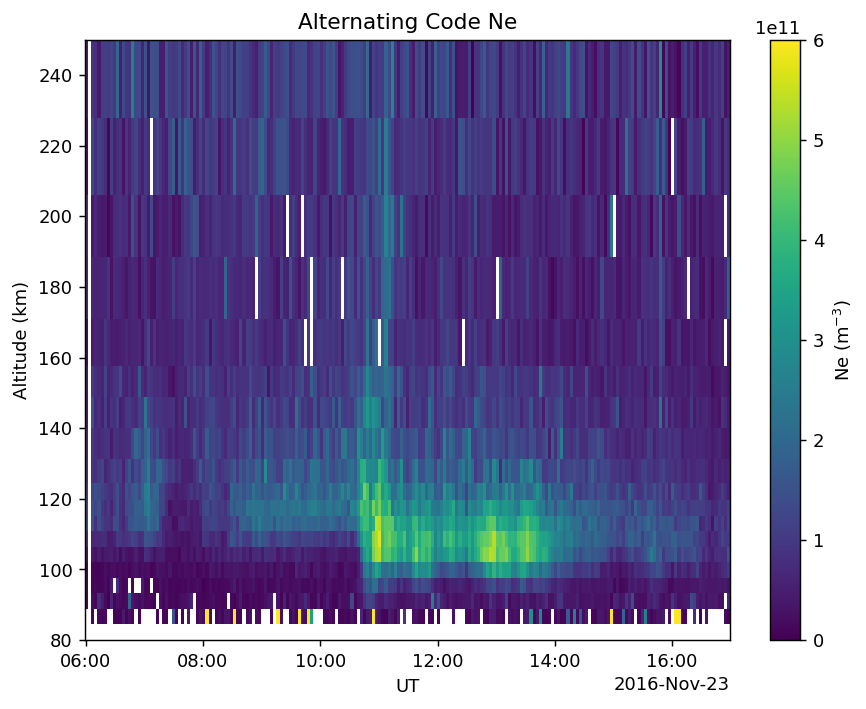

In [12]:
fig,ax=plt.subplots(figsize=(8,6), dpi=130)
clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude']/1e3,bdat['ne'],vmin=0,vmax=6e11,shading='nearest')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_ylim([80,250])

ax.set_xlabel('UT')
ax.set_ylabel('Altitude (km)')
ax.set_title('Alternating Code Ne')

cb=fig.colorbar(clrs)
cb.set_label('Ne (m$^{-3}$)')

# Questions

1. What is producing the E-region electron density in this plot?

2. How do the density profiles differ before and after 11 UT?

3. Use https://www.gi.alaska.edu/monitors/magnetometer/archive to find the Poker Flat Magnetometer data from this same date and time. Does anything special happen in the magnetometer data that lines up with an event in the PFISR data?